In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


# Imports

In [ ]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols

from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config


: 

In [24]:
# fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [50]:

config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'

## Mean & STDs

In [25]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})


In [26]:
agg1_stds.columns

Index(['circuit_name', 'mutation_num', 'sample_name',
       'precision_wrt_species-6',
       'precision_wrt_species-6_diff_to_base_circuit',
       'precision_wrt_species-6_ratio_from_mutation_to_base',
       'sensitivity_wrt_species-6',
       'sensitivity_wrt_species-6_diff_to_base_circuit',
       'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
       'num_interacting', 'num_self_interacting'],
      dtype='object')

In [27]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)


In [28]:
# sns.jointplot(agg1_stds, x='precision_wrt_species-6', y='sensitivity_wrt_species-6', alpha=0.1)
# plt.xscale('log')

Find joint min of precision and std differences between all circuits and max of precision STD difference. Flip into a maximisation problem. 

Get circuit indices for filtered aggregated data and make dataframes for the chosen circuits.

In [29]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (
    agg1_mean['precision_wrt_species-6'] > 1) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()
st = agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()

std_diffs = np.log(st[:, None] / st[None, :])
prec_diffs = np.log(p[:, None] / p[None, :])
sens_diffs = np.log(s[:, None] / s[None, :])

std_diffs = np.where(np.isnan(std_diffs) | (np.abs(std_diffs) == np.inf), 0, std_diffs)
weighting_prec = 1
weighting_sens = 1
weighting_stds = 0.1
joint_diffs = weighting_prec * np.abs(prec_diffs) + weighting_sens * np.abs(sens_diffs)
joint_diffs_rev = np.where(joint_diffs != 0, joint_diffs.max() - np.abs(joint_diffs), 0)
joint = joint_diffs_rev + weighting_stds * np.abs(std_diffs)

circ1, circ2 = np.where(joint == np.abs(joint).max()) 
circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]


/tmp/ipykernel_78367/1889599552.py:8: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_78367/1889599552.py:8: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_78367/1889599552.py:8: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


In [30]:
joint_diffs[joint_diffs != 0].min()

6.397283027115316e-05

In [31]:
joint_diffs.max()

21.7093924311867

In [32]:
np.abs(std_diffs).max()

18.386397183460154

In [33]:
joint.max()

22.64101166911541

In [34]:
print(joint[circ1[0], circ2[0]])
print(joint_diffs_rev[circ1[0], circ2[0]])
print(joint_diffs[circ1[0], circ2[0]])
print(std_diffs[circ1[0], circ2[0]])
print(prec_diffs[circ1[0], circ2[0]])
print(sens_diffs[circ1[0], circ2[0]])

22.64101166911541
21.62845769630686
0.08093473487983831
10.125539728085515
0.0180564285524611
0.0628783063273772


In [35]:
circ2_m_df

,circuit_name,mutation_num,sample_name,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,num_interacting,num_self_interacting
35924,toy_mRNA_circuit_11537,5,RNA_2,244515.630962,-4.153131e+06,0.055601,0.001492,0.001011,3.101436,1.033333,1.5


Narrow the selection.

In [36]:
data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ1_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
372080,toy_mRNA_circuit_10614,RNA_0_m3-0,3,"[6, 11, 5]","[1, 5, 18]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372083,toy_mRNA_circuit_10614,RNA_0_m3-1,3,"[5, 11, 3]","[13, 14, 0]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372086,toy_mRNA_circuit_10614,RNA_0_m3-2,3,"[4, 5, 9]","[0, 13, 5]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372098,toy_mRNA_circuit_10614,RNA_0_m3-6,3,"[9, 6, 4]","[15, 1, 0]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372101,toy_mRNA_circuit_10614,RNA_0_m3-7,3,"[1, 9, 9]","[17, 5, 3]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372107,toy_mRNA_circuit_10614,RNA_0_m3-9,3,"[9, 4, 4]","[4, 0, 9]",1,0,3.426551e+03,3.172238e+03,13.473795,0.000303,-0.003629,0.077023,RNA_2
372260,toy_mRNA_circuit_10614,RNA_1_m3-0,3,"[6, 5, 5]","[7, 13, 0]",1,0,3.072862e+03,2.818550e+03,12.083029,0.000325,-0.003607,0.082761,RNA_2
372263,toy_mRNA_circuit_10614,RNA_1_m3-1,3,"[7, 11, 0]","[2, 12, 15]",1,0,3.119854e+03,2.865542e+03,12.267812,0.000321,-0.003612,0.081514,RNA_2
372269,toy_mRNA_circuit_10614,RNA_1_m3-3,3,"[7, 11, 2]","[7, 8, 10]",0,1,2.998267e+03,2.743955e+03,11.789709,0.000334,-0.003599,0.084820,RNA_2
372272,toy_mRNA_circuit_10614,RNA_1_m3-4,3,"[8, 0, 2]","[14, 15, 16]",1,0,3.221164e+03,2.966852e+03,12.666180,0.000310,-0.003622,0.078950,RNA_2


In [37]:

data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ2_m_df['sample_name'].values[0]) ][
    ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,num_interacting,num_self_interacting,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
928685,toy_mRNA_circuit_11537,RNA_0_m5-0,5,"[7, 8, 1, 2, 6]","[2, 18, 12, 7, 8]",1,2,3201.68140,-4394445.0,0.000728,0.000312,-0.000169,0.649429,RNA_2
928691,toy_mRNA_circuit_11537,RNA_0_m5-2,5,"[1, 10, 5, 10, 2]","[12, 5, 3, 13, 1]",1,2,3201.68140,-4394445.0,0.000728,0.000312,-0.000169,0.649429,RNA_2
928694,toy_mRNA_circuit_11537,RNA_0_m5-3,5,"[2, 7, 11, 7, 3]","[17, 2, 5, 10, 3]",1,2,3201.68140,-4394445.0,0.000728,0.000312,-0.000169,0.649429,RNA_2
928700,toy_mRNA_circuit_11537,RNA_0_m5-5,5,"[2, 0, 2, 1, 0]","[17, 9, 1, 14, 7]",1,3,12184.36900,-4385462.0,0.002771,0.000133,-0.000348,0.275690,RNA_2
928712,toy_mRNA_circuit_11537,RNA_0_m5-9,5,"[0, 0, 8, 8, 5]","[7, 16, 10, 15, 0]",1,3,7937.74000,-4389709.0,0.001805,0.000170,-0.000311,0.352642,RNA_2
928865,toy_mRNA_circuit_11537,RNA_1_m5-0,5,"[0, 0, 5, 5, 9]","[4, 15, 2, 8, 16]",0,1,2992.87260,-4394653.5,0.000681,0.000334,-0.000147,0.694739,RNA_2
928868,toy_mRNA_circuit_11537,RNA_1_m5-1,5,"[10, 9, 11, 9, 0]","[16, 17, 11, 5, 15]",0,1,2992.87260,-4394653.5,0.000681,0.000334,-0.000147,0.694739,RNA_2
928871,toy_mRNA_circuit_11537,RNA_1_m5-2,5,"[0, 0, 7, 8, 7]","[9, 7, 19, 3, 14]",0,1,2992.87260,-4394653.5,0.000681,0.000334,-0.000147,0.694739,RNA_2
928874,toy_mRNA_circuit_11537,RNA_1_m5-3,5,"[2, 11, 10, 8, 2]","[18, 17, 5, 19, 1]",2,1,253.98961,-4397392.5,0.000058,0.029917,0.029436,62.205395,RNA_2
928877,toy_mRNA_circuit_11537,RNA_1_m5-4,5,"[7, 11, 1, 4, 10]","[3, 0, 15, 2, 11]",1,1,3024.14010,-4394622.5,0.000688,0.000331,-0.000150,0.687556,RNA_2


In [38]:
# circuit_chosen_idx = circ1[0]
# circuit_chosen = data.iloc[circuit_chosen_idx]
# e_dir = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'], 'energies')
# energies = pd.read_csv(os.path.join(e_dir, os.listdir(e_dir)[0]))
# print(circuit_chosen[['circuit_name', 'mutation_name']])
# energies

## Check circuits chosen

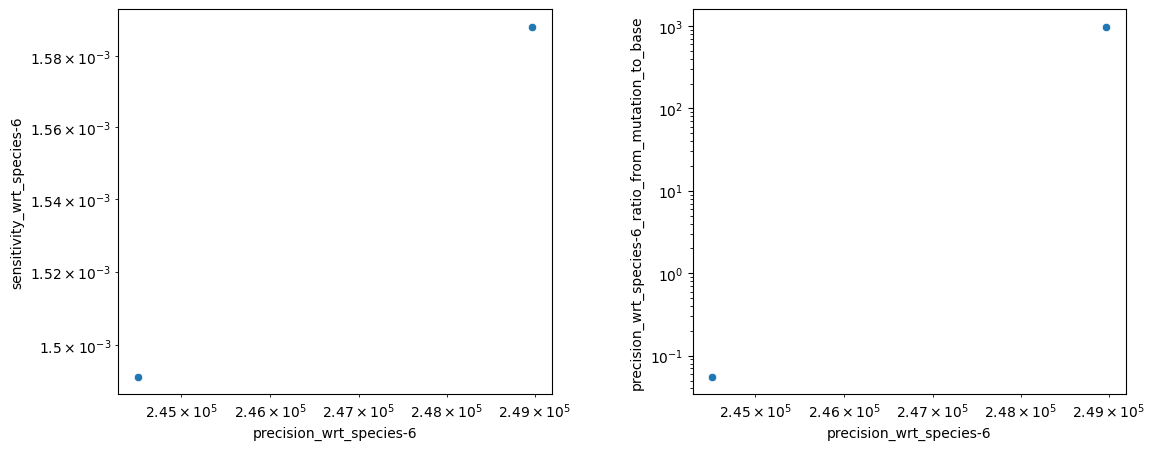

In [39]:


m_df = pd.concat([circ1_m_df, circ2_m_df])
s_df = pd.concat([circ1_m_df, circ2_m_df])

fig =plt.figure(figsize=(13, 5))
fig.subplots_adjust(wspace=0.325)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=m_df['precision_wrt_species-6'], y=m_df['sensitivity_wrt_species-6'])
plt.yscale('log')
plt.xscale('log')
ax = plt.subplot(1,2,2)
sns.scatterplot(x=s_df['precision_wrt_species-6'], y=s_df['precision_wrt_species-6_ratio_from_mutation_to_base'])
plt.yscale('log')
plt.xscale('log')


Text(0.5, 0.98, 'Precision mean for $RNA_2$')

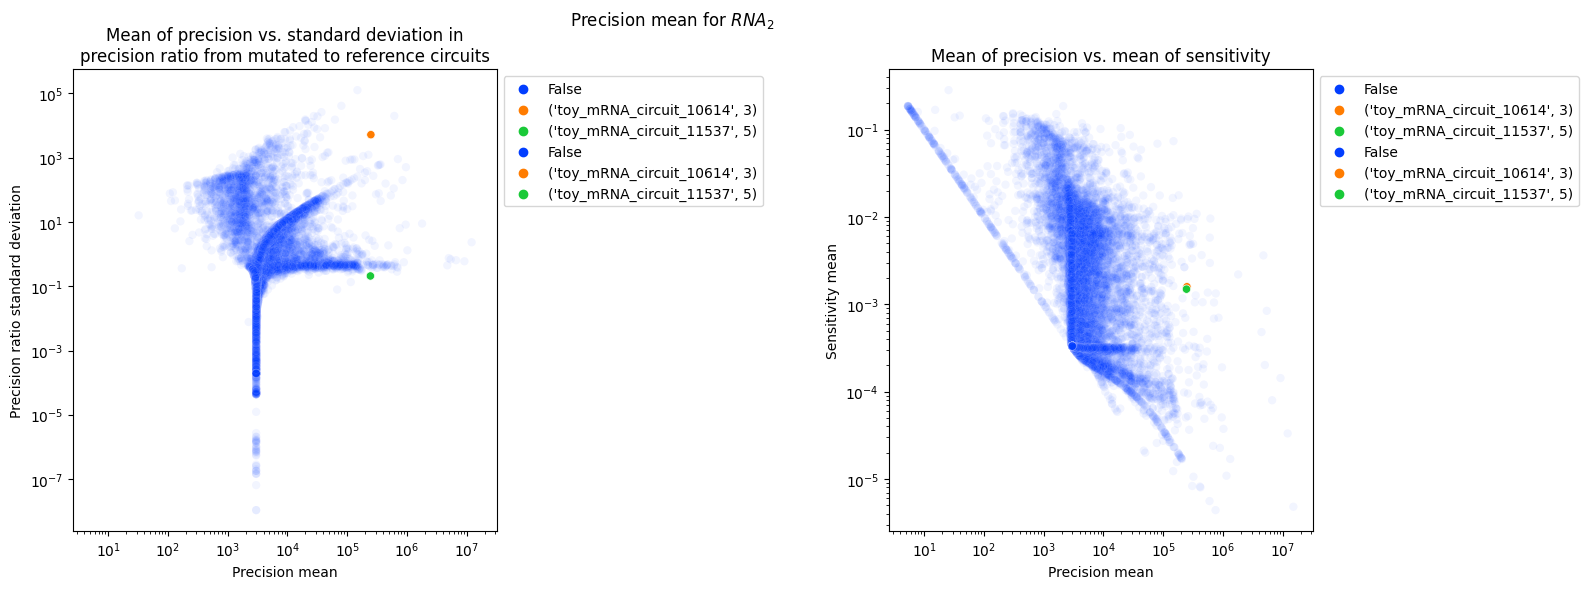

In [40]:

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
hue_d = {c1n: c1m, c2n: c2m}
# hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values))
hue = list(map(lambda i, c, m: (c, m) if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean[filt].index), list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio standard deviation')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,2,2)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette="bright")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precision mean')
plt.ylabel('Sensitivity mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')



In [41]:
np.log10(agg1_mean[(agg1_mean['circuit_name'].isin([c1n, c2n])) & (agg1_mean['mutation_num'].isin([c1m, c2m])) & (agg1_mean['sample_name'] == 'RNA_2')]['precision_wrt_species-6'])

14396    5.396148
14399    3.444554
35921    5.744817
35924    5.388307
Name: precision_wrt_species-6, dtype: float64

## Load circuits

In [42]:


def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if length == 1:
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=config))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=config))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_0')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_0')]
circuits1 = batch_load(circ_rows1, ref_c1)
circuits2 = batch_load(circ_rows2, ref_c2)
circuits = circuits1 + circuits2

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, 5000))
                            )))


xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


### Simulate

In [44]:


signal = circuits[0].signal
signal_target = signal.func.keywords['target']

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)

signal_species = 'RNA_0'
signal_species_idx = np.where(circuits1[0].signal.onehot)[0][0]

b_steady_states = b_copynumbers[:, :, -1]
# b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0] * signal_target

b_steady_states = (b_copynumbers[:, :, -1] * ((signal.onehot == 0) * 1)) + \
    (b_copynumbers[:, :, 0] *
     signal_target) * signal.onehot




Done:  0:01:23.351983


In [45]:

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)



Steady states:  200.0  iterations.  47  left to steady out.  0:01:20.488569
Done:  0:02:41.801570


In [ ]:
# Fix first entry for prec / sensitivity calculations
for i, c in enumerate(circuits): 
    if not c.use_prod_and_deg:
        b_new_copynumbers[i, :, :] = np.concatenate([np.expand_dims(b_copynumbers[i, :, -1], axis=1), b_new_copynumbers[i, :, :-1]], axis=1)

### Visualise

In [46]:
len(circuits)

45

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

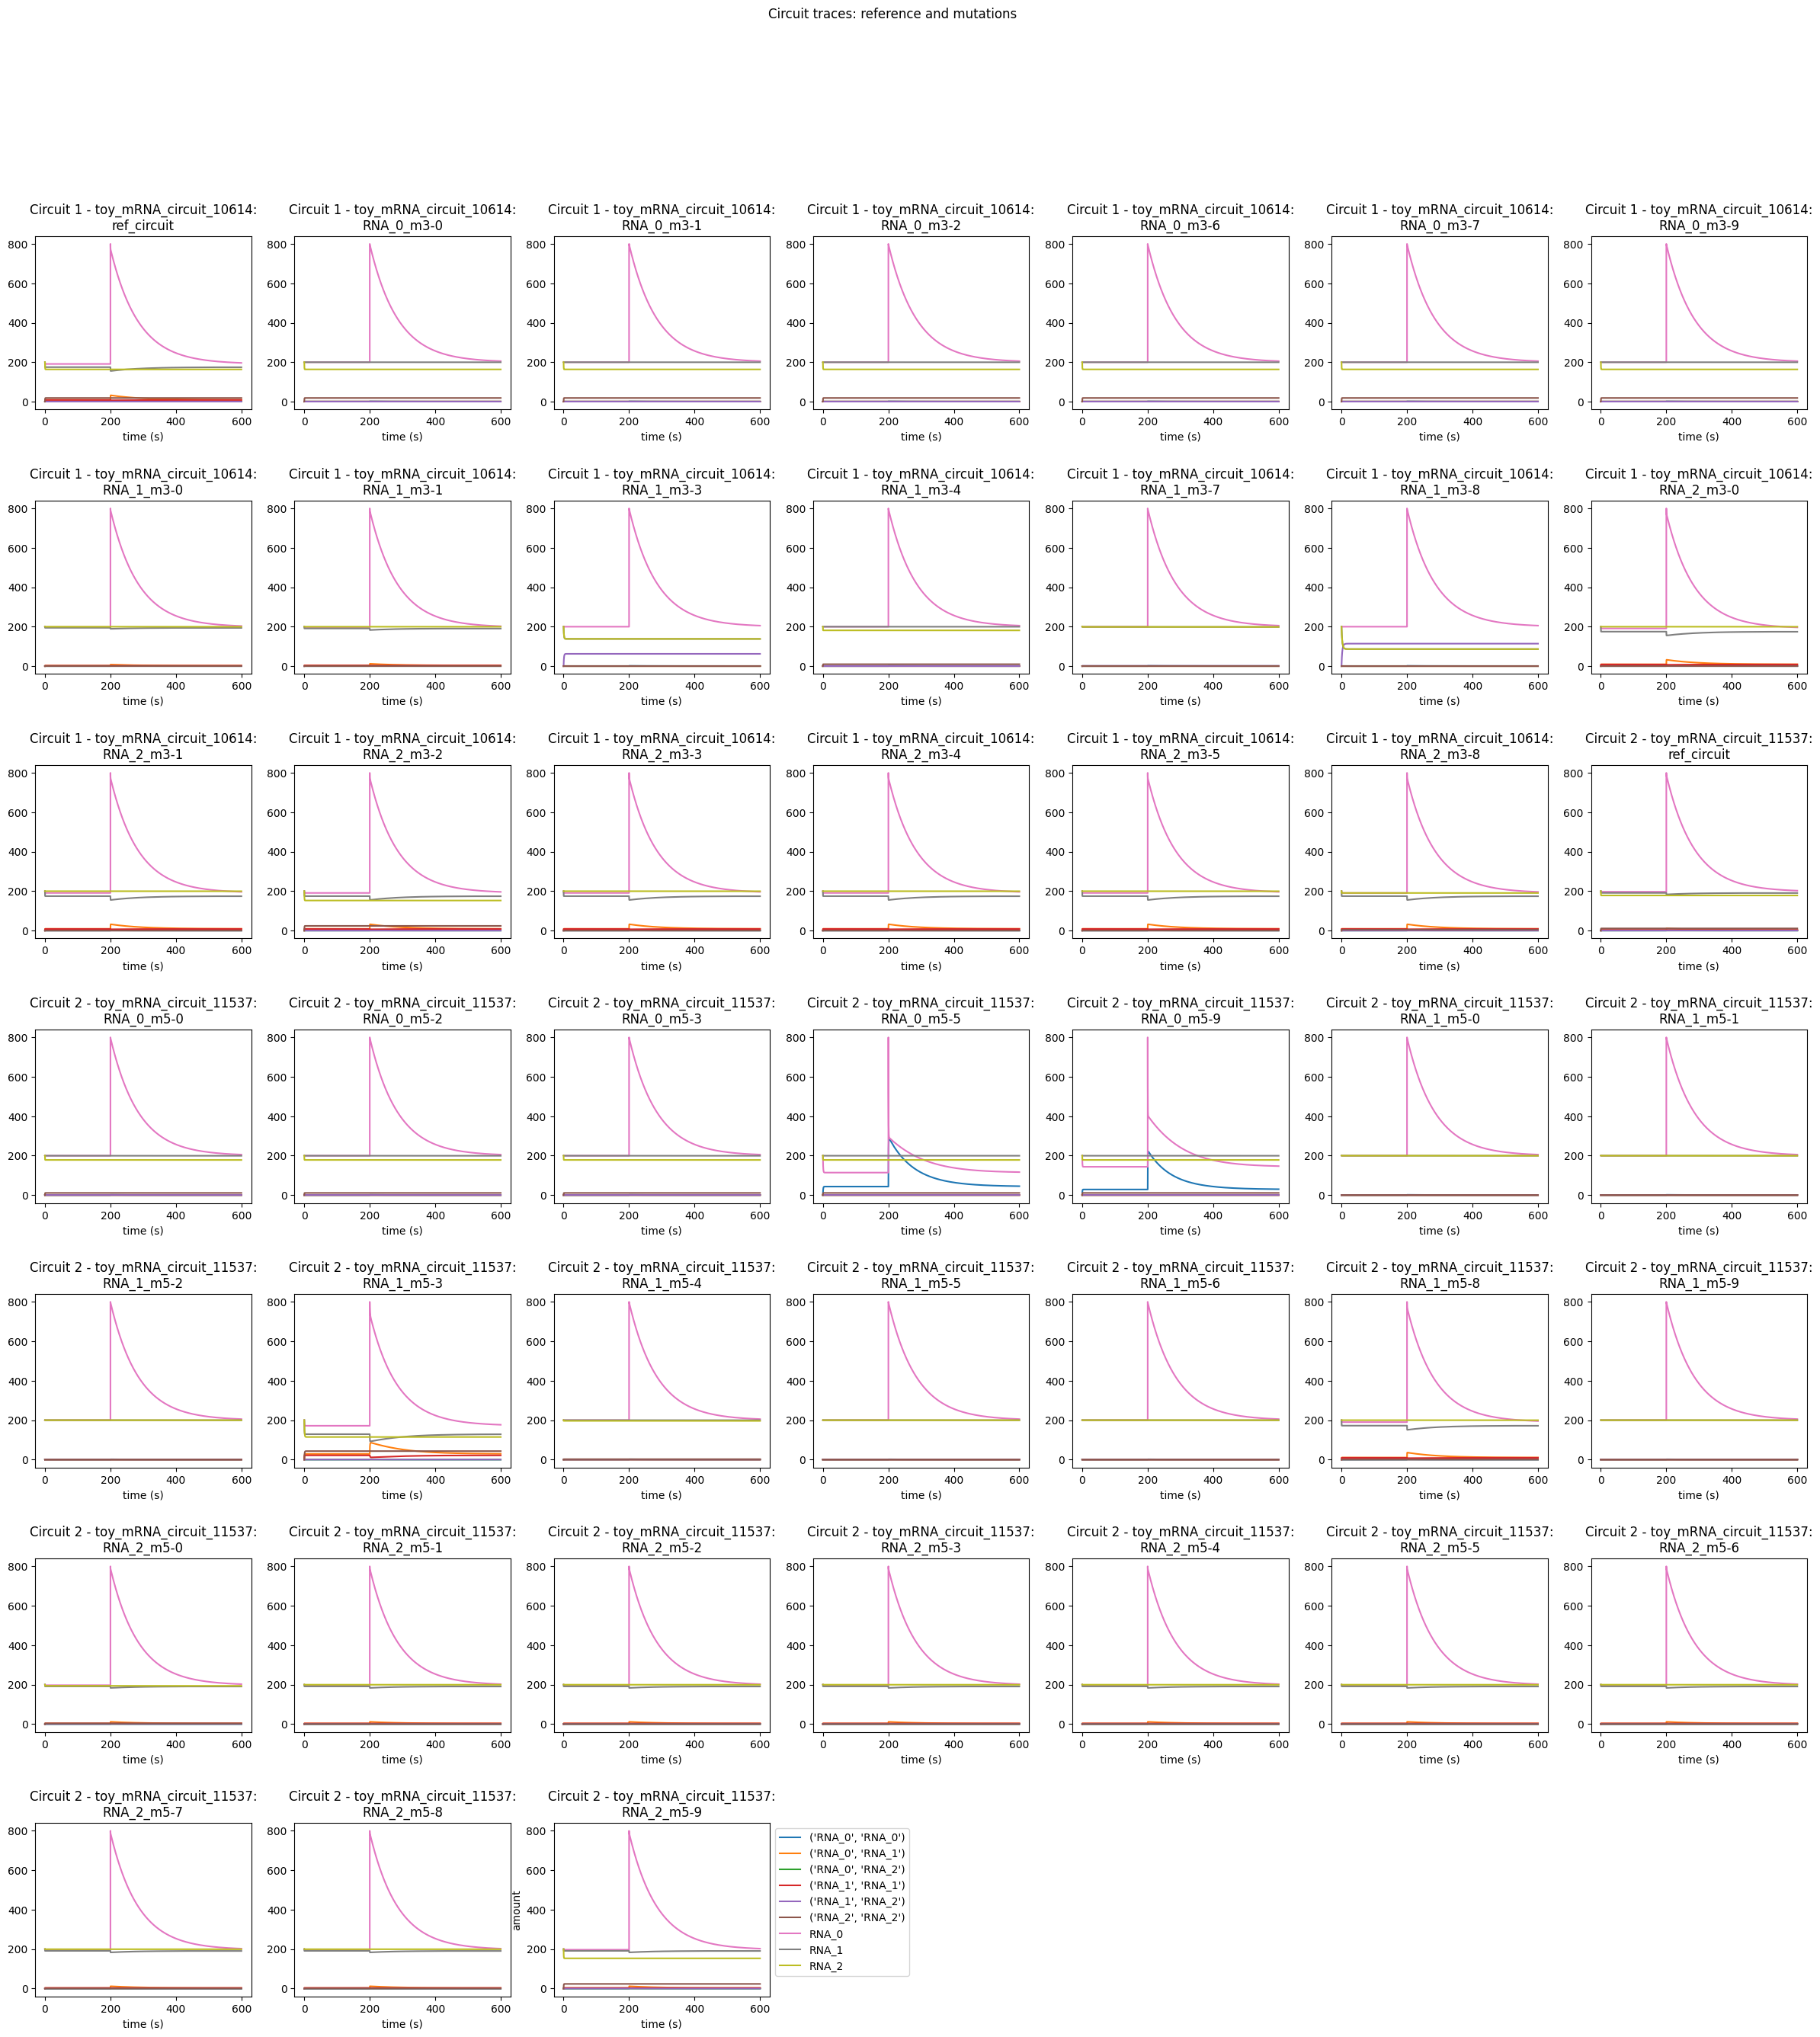

In [47]:
num_circuits = len(circuits)
nm=0
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{circ_type} - {circuits[i].name}:\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


### Zoomed in at beginning of time trace

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

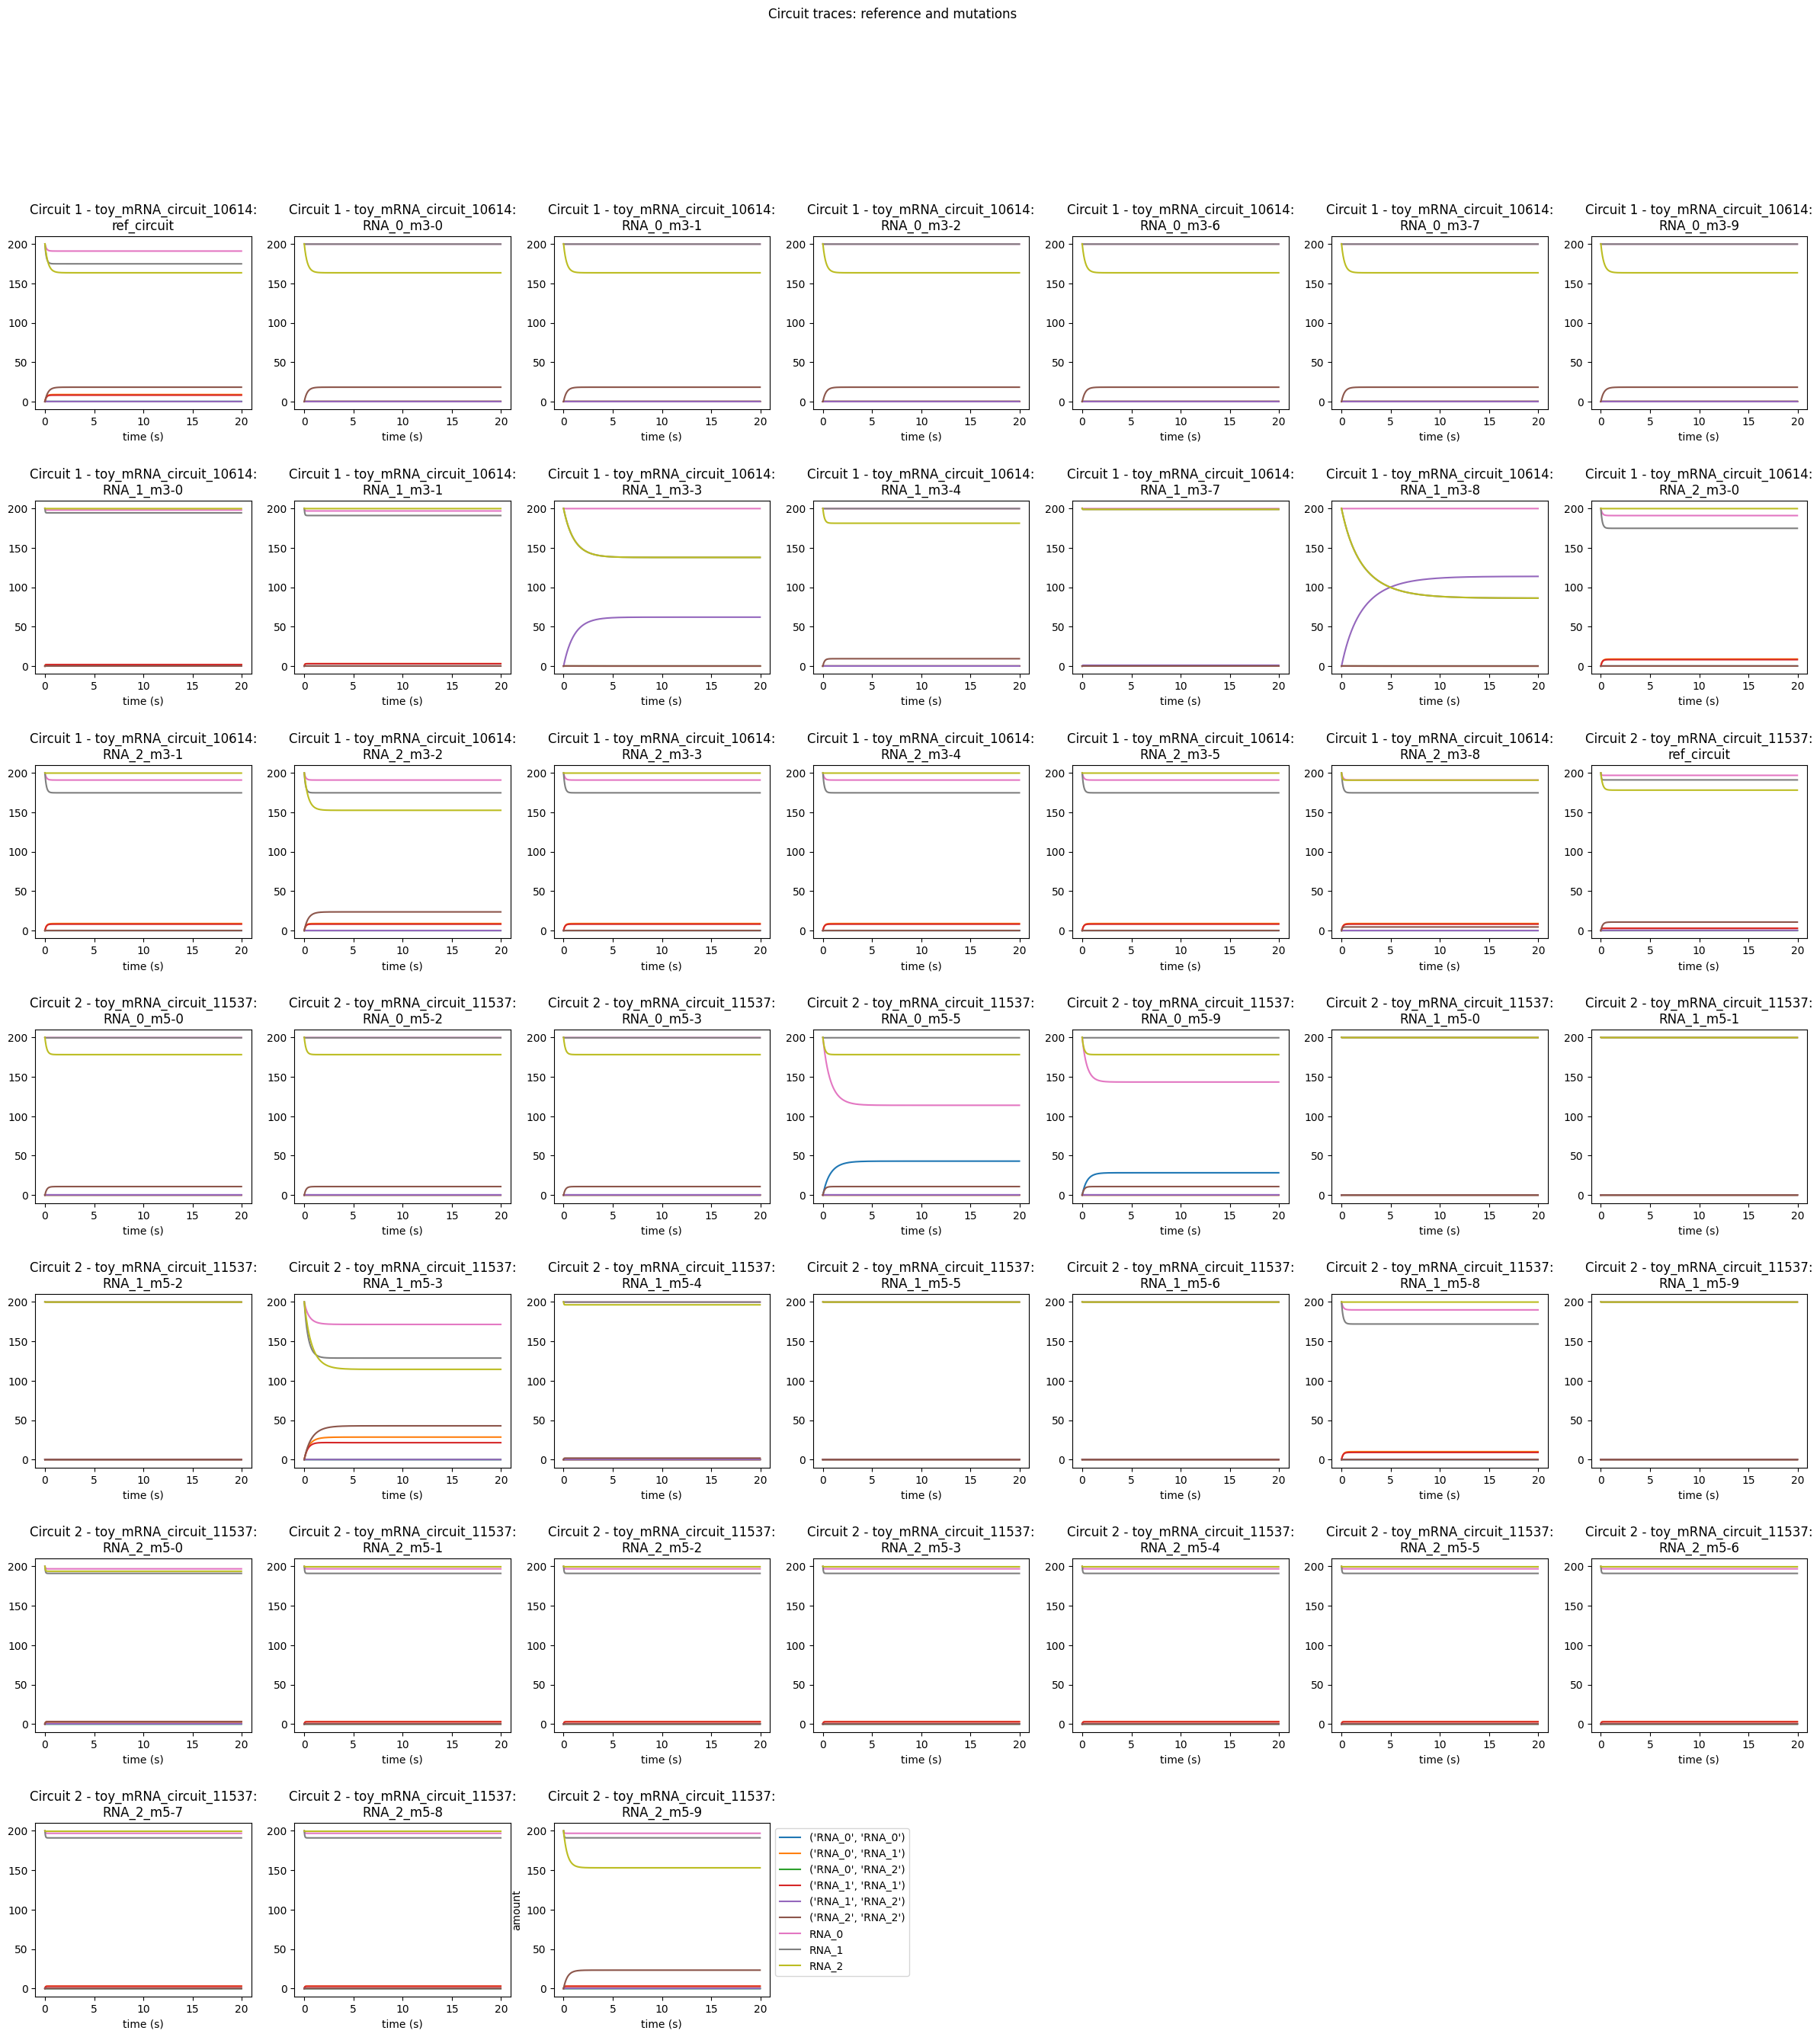

In [48]:
num_circuits = len(circuits)
nm=0
tdisplay = 500
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[:tdisplay], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[:tdisplay])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{circ_type} - {circuits[i].name}:\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')
